In [1]:
import pandas as pd
from sklearn import preprocessing

data_dir = './data/'
spotify_dir = 'archive/'


In [2]:
def combineFeatures():
    # read the billboard audio features file
    billboard_data = pd.read_csv(data_dir + spotify_dir + 'BillboardAudioFeatures.csv')
    # rename the billboard audio features file
    billboard_data = billboard_data.rename(
        columns={"Performer": "artist_name", "Song": "track_name", "spotify_genre": "genre",
                 "spotify_track_id": "track_id", "spotify_track_popularity": "popularity",
                 "spotify_track_duration_ms": "duration_ms"})

    # drop the columns from the billboard data set that are not in the Kaggle Dataset
    billboard_data = billboard_data.drop(
        ['SongID', 'spotify_track_preview_url', 'spotify_track_album', 'spotify_track_explicit',
         'time_signature'], axis=1)

    # reformat the data columns in the billboard data to match the kaggle
    # everything ended ups getting changed with the pre=processing anyways... so need to figure out what to update
    di = {0: "Minor", 1: "Major"}
    billboard_data['mode'] = billboard_data['mode'].map(di)
    
    # delete the rows that have no values for the audio features
    dict = {"" : 'nan'}
    billboard_data = billboard_data.replace(dict)
    billboard_data = billboard_data.dropna()
    billboard_data = billboard_data.reset_index()
    billboard_data = billboard_data.drop(billboard_data.columns[0], axis=1)
    
    # creating a dictionary to rename the genres in the billboard file
    final_attempt = {}
    index = -1
    for row in billboard_data.itertuples():
        index = index + 1
        #print(index)
        #print(row[3])
        if 'a capella' in row[3]:
            final_attempt[index] = 'A Capella'
        elif 'alternative' in row[3]:
            final_attempt[index] = 'Alternative'
        elif 'anime' in row[3]:
            final_attempt[index] = 'Anime'
        elif 'blues' in row[3]:
            final_attempt[index] = 'Blues'
        elif 'childrens music' in row[3]:
            final_attempt[index] = "Children's Music"
        elif 'classical' in row[3]:
            final_attempt[index] = 'Classical'
        elif 'comedy' in row[3]:
            final_attempt[index] = 'Comedy'
        elif 'country' in row[3]:
            final_attempt[index] = 'Country'
        elif 'dance' in row[3]:
            final_attempt[index] = 'Dance'
        elif 'electronic' in row[3]:
            final_attempt[index] = 'Electronic'
        elif 'folk' in row[3]:
            final_attempt[index] = 'Folk'
        elif 'hip hop' in row[3]:
            final_attempt[index] = 'Hip-Hop'
        elif 'indie' in row[3]:
            final_attempt[index] = 'Indie'
        elif 'jazz' in row[3]:
            final_attempt[index] = 'Jazz'
        elif 'movie' in row[3]:
            final_attempt[index] = 'Movie'
        elif 'opera' in row[3]:
            final_attempt[index] = 'Opera'
        elif 'pop' in row[3]:
            final_attempt[index] = 'Pop'
        elif 'r&b' in row[3]:
            final_attempt[index] = 'R&B'
        elif 'rap' in row[3]:
            final_attempt[index] = 'Rap'
        elif 'reggae' in row[3]:
            final_attempt[index] = 'Reggae'
        elif 'reggaeton' in row[3]:
            final_attempt[index] = 'Reggaeton'
        elif 'rock' in row[3]:
            final_attempt[index] = 'Rock'
        elif 'ska' in row[3]:
            final_attempt[index] = 'Ska'
        elif 'soul' in row[3]:
            final_attempt[index] = 'Soul'
        elif 'soundtrack' in row[3]:
            final_attempt[index] = 'Soundtrack'
        elif 'world' in row[3]:
            final_attempt[index] = 'World'
        else:
            final_attempt[index] = 'Other'
    
    #print(final_attempt)
    
    # adding in a new column to be able to map the genre values to 
    billboard_data['new_genre'] = "N/A"
    for i in range(0,23565):
        billboard_data['new_genre'][i] = i
    # mapping the genre values to the correct row
    billboard_data['new_genre'] = billboard_data['new_genre'].map(final_attempt)
    
    # dropping the old genre column and renaming to have the same column header format
    billboard_data = billboard_data.drop(
        ['genre'], axis=1)
    billboard_data = billboard_data.rename(
        columns={"new_genre": "genre"})
    
    # read the kaggle data set to prepare to append the new rows
    kaggle_data = pd.read_csv(data_dir + spotify_dir + 'SpotifyFeatures.csv')
    kaggle_data = kaggle_data.drop_duplicates(subset=['track_id'])
    kaggle_data = kaggle_data.drop(['time_signature'], axis=1)

    # append the billboard data to the kaggle data
    kaggle_data = kaggle_data.append(billboard_data)

    # save the data to a new file and use this for the rest of the code
    # the test.csv is just for me to check the billboard data
    billboard_data.to_csv(data_dir + spotify_dir + 'test.csv')
    kaggle_data.to_csv(data_dir + spotify_dir + 'ExtraSpotifyData.csv')


In [3]:
def preprocess(filename):
    data = pd.read_csv(data_dir + spotify_dir + filename)

    # update the key
    d1 = {'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11}
    data['key'] = data['key'].replace(d1)

    d2 = {"Minor": 0, "Major": 1}
    data['mode'] = data['mode'].map(d2)

    # map categoricals to ints
    data['genre'] = pd.Categorical(data.genre, ordered=True).codes

    data = normalize_cols(data, ['duration_ms', 'loudness', 'tempo'])

    data.to_csv(data_dir + 'SpotifyFeaturesPreprocessed.csv')

In [4]:
def matchBillboard():
    billboard_data = pd.read_csv(data_dir + spotify_dir + 'BillboardHits.csv')

    billboard_arr = []
    for index, row in billboard_data.iterrows():
        new_element = [row['Song'].lower(), row['Performer'].lower()]
        billboard_arr.append(new_element)

    spotify_data = pd.read_csv(data_dir + 'SpotifyFeaturesPreprocessed.csv')
    spotify_dict = {}

    # I think we also need to match on genre because right now it is only updating one instance of a song
    # or when we remove duplicates we need to keep the instance thats has the 1 for accurate results
    for index, row in spotify_data.iterrows():
        spotify_dict[(row['track_name'].lower(), row['artist_name'].lower())] = index

    spotify_data['billboardhit'] = 0

    match_count = 0
    for billboard_tuple in billboard_arr:
        spotify_row = spotify_dict.get((billboard_tuple[0], billboard_tuple[1]))
        if spotify_row:
            match_count = match_count + 1
            spotify_data['billboardhit'][spotify_row] = 1

    print(match_count)
    spotify_data = spotify_data.drop(['artist_name', 'track_id','track_name'], axis=1)
    spotify_data = spotify_data.drop(spotify_data.columns[0], axis=1)
    spotify_data = spotify_data.drop(spotify_data.columns[0], axis=1)

    spotify_data.to_csv(data_dir + 'SpotifyFeaturesBillboard.csv')

In [5]:
def normalize_cols(data, cols):
    for col in cols:
        # Create x, where x the 'scores' column's values as floats
        x = data[[col]].values.astype(float)

        # Create a minimum and maximum processor object
        min_max_scaler = preprocessing.MinMaxScaler()

        # Create an object to transform the data to fit minmax processor
        x_scaled = min_max_scaler.fit_transform(x)

        # Run the normalizer on the dataframe
        data[col] = pd.DataFrame(x_scaled)
    return data

In [6]:
def categorical_to_int(data, col):
    data[col] = len(data) - pd.Categorical(data.genre, ordered=True).codes
    return data

In [7]:
combineFeatures()
preprocess('ExtraSpotifyData.csv')
matchBillboard()

<ipython-input-2-ed921e47ca8f>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billboard_data['new_genre'][i] = i
C:\Users\16cm67\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-4-29010b2d08fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_data['billboardhit'][spotify_row] = 1


279830


In [7]:
def binarizeData(file): 
    pre_data = pd.read_csv(file).drop_duplicates()
    pre_data.drop(columns = ['duration_ms', 'key', 'mode', 'tempo','Unnamed: 0','popularity'],inplace = True)
    #pre_data['liveness'] = pre_data['liveness'].apply(lambda x: 1 if x >= .8 else 0)
    #pre_data['speechiness'] = pre_data['speechiness'].apply(lambda x: 2 if x >= .66 else 1 if (x <= .66 and x >= .33) else 0)
    #pre_data['energy'] = pre_data['energy'].apply(lambda x: 1 if x >= .5 else 0)
    #pre_data['danceability'] = pre_data['danceability'].apply(lambda x: 1 if x >= .5 else 0)
    #pre_data['acousticness'] = pre_data['acousticness'].apply(lambda x: 1 if x >= .5 else 0)
    #pre_data['instrumentalness'] = pre_data['instrumentalness'].apply(lambda x: 1 if x >= .5 else 0)
    #pre_data['valence'] = pre_data['valence'].apply(lambda x: 1 if x >= .5 else 0)
    #pre_data['loudness'] = pre_data['loudness'].apply(lambda x: 1 if x >= .5 else 0)
    
    return pre_data

In [8]:
# import libraries
from pycaret.classification import *
import pandas as pd
# read in your stock data
spotify = binarizeData(data_dir + 'SpotifyFeaturesBillboard.csv')
y = spotify['billboardhit']
spotify.drop(columns = ['billboardhit'],inplace = True)

<AxesSubplot:>

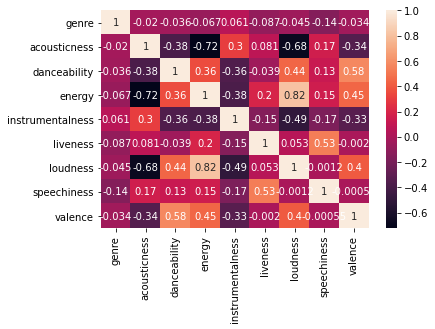

In [9]:
import seaborn as sn
sn.heatmap(spotify.corr(), annot=True)

In [10]:
from collections import Counter
from imblearn.over_sampling import SMOTE
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
spotify, y = oversample.fit_resample(spotify, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)


Counter({0: 176756, 1: 23583})
Counter({0: 176756, 1: 176756})


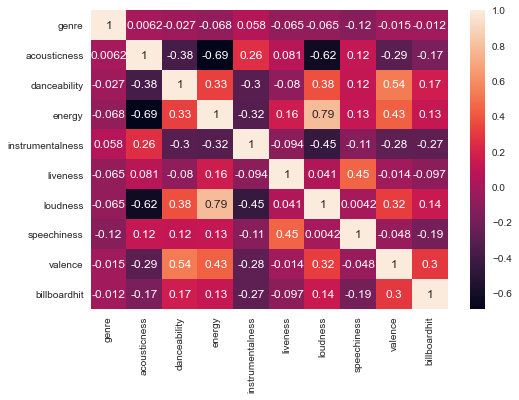

In [33]:
spotify['billboardhit'] = y 
import seaborn as sn
sn.heatmap(spotify.corr(), annot=True)
spotify = spotify.sample(frac = 1)
spotify, spotify_test = spotify[0:325000], spotify[325001:]

# setup your regression parameters/// NON BINARIZED
regression = setup(data = new_df, target = "billboardhit",session_id = 100)
# compare models
compare_models()
# create a model

In [7]:
# setup your regression parameters ///Binarized
regression = setup(data = new_df, target = "billboardhit",session_id = 100)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8453,0.9111,0.6972,0.9909,0.8185,0.6907,0.7232,0.1640
catboost,CatBoost Classifier,0.8450,0.9128,0.7001,0.9860,0.8188,0.6900,0.7210,10.8260
dt,Decision Tree Classifier,0.8449,0.9116,0.7029,0.9819,0.8192,0.6898,0.7195,0.0190
lightgbm,Light Gradient Boosting Machine,0.8449,0.9125,0.7022,0.9830,0.8191,0.6899,0.7200,0.1440
rf,Random Forest Classifier,0.8446,0.9117,0.7039,0.9797,0.8191,0.6892,0.7183,0.1540
xgboost,Extreme Gradient Boosting,0.8446,0.9126,0.7012,0.9833,0.8186,0.6892,0.7194,0.3450
et,Extra Trees Classifier,0.8438,0.9111,0.7017,0.9807,0.8180,0.6877,0.7174,0.1440
ada,Ada Boost Classifier,0.8398,0.9091,0.7097,0.9636,0.8159,0.6797,0.7061,0.0770
knn,K Neighbors Classifier,0.8266,0.8709,0.7454,0.8968,0.8116,0.6533,0.6659,0.3510
ridge,Ridge Classifier,0.7302,0.0000,0.7125,0.7417,0.7254,0.4603,0.4623,0.0180


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
# setup your regression parameters ///Binarized without valence and loudness
regression = setup(data = new_df, target = "billboardhit",session_id = 100,use_gpu = True)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8448,0.9058,0.6949,0.9926,0.8175,0.6897,0.7230,0.7460
catboost,CatBoost Classifier,0.8447,0.9075,0.6983,0.9877,0.8181,0.6895,0.7212,7.2110
ada,Ada Boost Classifier,0.8446,0.9039,0.6951,0.9919,0.8173,0.6893,0.7224,0.3720
dt,Decision Tree Classifier,0.8443,0.9069,0.6991,0.9854,0.8179,0.6886,0.7197,0.0260
rf,Random Forest Classifier,0.8443,0.9072,0.6994,0.9851,0.8180,0.6887,0.7197,0.6360
lightgbm,Light Gradient Boosting Machine,0.8443,0.9074,0.6991,0.9855,0.8179,0.6887,0.7198,0.1920
et,Extra Trees Classifier,0.8440,0.9069,0.6986,0.9853,0.8175,0.6880,0.7192,0.6360
knn,K Neighbors Classifier,0.8211,0.8708,0.7386,0.8917,0.8058,0.6423,0.6548,0.5730
ridge,Ridge Classifier,0.7727,0.0000,0.6508,0.8607,0.7412,0.5454,0.5624,0.0190
lda,Linear Discriminant Analysis,0.7726,0.8136,0.6507,0.8606,0.7411,0.5452,0.5622,0.0510


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
# setup your regression parameters ///NON Binarized without valence and loudness
regression = setup(data = new_df, target = "billboardhit",session_id = 100,use_gpu = True)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8460,0.9099,0.7046,0.9825,0.8206,0.6919,0.7214,2.8450
ada,Ada Boost Classifier,0.8450,0.9069,0.7049,0.9795,0.8198,0.6900,0.7189,0.7160
lightgbm,Light Gradient Boosting Machine,0.8444,0.9084,0.7134,0.9669,0.8210,0.6889,0.7139,0.2150
catboost,CatBoost Classifier,0.8424,0.9066,0.7226,0.9507,0.8210,0.6849,0.7056,9.9970
knn,K Neighbors Classifier,0.8154,0.8796,0.7474,0.8652,0.8020,0.6308,0.6368,0.5340
rf,Random Forest Classifier,0.8064,0.8693,0.7264,0.8649,0.7896,0.6128,0.6208,1.0950
et,Extra Trees Classifier,0.8042,0.8070,0.7255,0.8614,0.7876,0.6085,0.6163,2.4160
dt,Decision Tree Classifier,0.7647,0.7650,0.7683,0.7630,0.7656,0.5294,0.5294,0.1490
ridge,Ridge Classifier,0.7646,0.0000,0.6632,0.8322,0.7381,0.5292,0.5405,0.0180
lda,Linear Discriminant Analysis,0.7646,0.8216,0.6631,0.8322,0.7380,0.5292,0.5405,0.0380


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
# setup your regression parameters ///NON Binarized with valence and loudness, tempo,mode,duration,key
regression = setup(data = new_df, target = "billboardhit",session_id = 100,use_gpu = True)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8458,0.9140,0.7072,0.9786,0.8210,0.6916,0.7199,4.3520
ada,Ada Boost Classifier,0.8451,0.9087,0.7051,0.9797,0.8199,0.6903,0.7192,1.0090
lightgbm,Light Gradient Boosting Machine,0.8446,0.9145,0.7203,0.9588,0.8225,0.6892,0.7116,0.2420
catboost,CatBoost Classifier,0.8410,0.9128,0.7304,0.9382,0.8213,0.6821,0.6995,10.3450
knn,K Neighbors Classifier,0.8161,0.8778,0.7449,0.8686,0.8020,0.6321,0.6387,0.4910
rf,Random Forest Classifier,0.8096,0.8730,0.7293,0.8690,0.7930,0.6192,0.6274,1.2890
et,Extra Trees Classifier,0.8058,0.8085,0.7281,0.8622,0.7895,0.6115,0.6191,2.4210
dt,Decision Tree Classifier,0.7683,0.7682,0.7746,0.7651,0.7698,0.5365,0.5367,0.2180
ridge,Ridge Classifier,0.7600,0.0000,0.6627,0.8231,0.7342,0.5200,0.5303,0.0190
lda,Linear Discriminant Analysis,0.7600,0.8232,0.6625,0.8233,0.7342,0.5201,0.5304,0.0480


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
# setup your regression parameters ///Binarized with valence and loudness, tempo,mode,duration,key
regression = setup(data = new_df, target = "billboardhit",session_id = 100,use_gpu = True)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8436,0.9145,0.7113,0.9672,0.8197,0.6873,0.7127,0.2250
gbc,Gradient Boosting Classifier,0.8428,0.9152,0.6965,0.9844,0.8157,0.6855,0.7168,2.3660
catboost,CatBoost Classifier,0.8414,0.9140,0.7252,0.9447,0.8205,0.6828,0.7021,10.0700
ada,Ada Boost Classifier,0.8405,0.9113,0.7141,0.9557,0.8173,0.6811,0.7040,0.6770
knn,K Neighbors Classifier,0.8149,0.8791,0.7540,0.8585,0.8028,0.6297,0.6345,0.5350
rf,Random Forest Classifier,0.7929,0.8658,0.7453,0.8236,0.7824,0.5858,0.5885,1.1410
et,Extra Trees Classifier,0.7811,0.7964,0.7516,0.7987,0.7744,0.5623,0.5633,2.5420
dt,Decision Tree Classifier,0.7636,0.7638,0.7674,0.7615,0.7644,0.5272,0.5273,0.1060
ridge,Ridge Classifier,0.7406,0.0000,0.6804,0.7733,0.7239,0.4811,0.4847,0.0200
lda,Linear Discriminant Analysis,0.7406,0.8307,0.6803,0.7734,0.7238,0.4811,0.4847,0.0680


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
# setup your regression parameters/// WITH POPULARITY
regression = setup(data = new_df, target = "billboardhit",session_id = 100,use_gpu = True)
# compare models
compare_models()
# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8950,0.9697,0.9079,0.9427,0.9249,0.7503,0.7519,3.6800
lightgbm,Light Gradient Boosting Machine,0.8900,0.9681,0.9048,0.9387,0.9214,0.7384,0.7400,0.1160
gbc,Gradient Boosting Classifier,0.8889,0.9657,0.9113,0.9314,0.9212,0.7328,0.7337,0.3410
ada,Ada Boost Classifier,0.8806,0.9593,0.9105,0.9213,0.9157,0.7108,0.7115,0.1620
knn,K Neighbors Classifier,0.8705,0.9487,0.8984,0.9181,0.9081,0.6887,0.6892,0.3100
dt,Decision Tree Classifier,0.8461,0.8195,0.8847,0.8980,0.8912,0.6282,0.6286,0.0160
rf,Random Forest Classifier,0.8457,0.9295,0.8952,0.8892,0.8921,0.6211,0.6214,0.5030
et,Extra Trees Classifier,0.8358,0.8031,0.8868,0.8833,0.8850,0.5977,0.5980,0.5350
ridge,Ridge Classifier,0.7586,0.0000,0.9266,0.7774,0.8455,0.3132,0.3403,0.0100
lda,Linear Discriminant Analysis,0.7544,0.7730,0.9108,0.7810,0.8409,0.3162,0.3353,0.0200


In [12]:
# setup your regression parameters/// WITH POPULARITY, binarized
regression = setup(data = spotify, target = "billboardhit",session_id = 100,use_gpu = True)

,Description,Value
0,session_id,100
1,Target,billboardhit
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(325000, 10)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [27]:
# compare models
compare_models()

# create a model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8960,0.9350,0.9353,0.8675,0.9001,0.7920,0.7945,7.9320
rf,Random Forest Classifier,0.8892,0.9515,0.9298,0.8603,0.8937,0.7785,0.7810,9.5660
knn,K Neighbors Classifier,0.8839,0.9339,0.9803,0.8221,0.8942,0.7677,0.7824,4.7170
lightgbm,Light Gradient Boosting Machine,0.8609,0.9386,0.9208,0.8227,0.8690,0.7218,0.7271,0.7540
catboost,CatBoost Classifier,0.8586,0.9357,0.9191,0.8202,0.8668,0.7171,0.7224,6.2550
dt,Decision Tree Classifier,0.8393,0.8462,0.8435,0.8369,0.8402,0.6786,0.6786,1.8380
gbc,Gradient Boosting Classifier,0.8356,0.9166,0.8928,0.8015,0.8447,0.6711,0.6756,33.8970
ada,Ada Boost Classifier,0.8019,0.8883,0.8505,0.7756,0.8113,0.6037,0.6066,7.3850
lr,Logistic Regression,0.6678,0.7307,0.7420,0.6467,0.6911,0.3354,0.3391,1.3560
ridge,Ridge Classifier,0.6647,0.0000,0.7560,0.6399,0.6931,0.3292,0.3348,0.0850


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=100, verbose=0,
                     warm_start=False)

In [13]:
catboost = create_model('et')
# predict on test set
predictions = predict_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8953,0.9301,0.9309,0.8691,0.8989,0.7905,0.7925
1,0.8971,0.9336,0.9351,0.8692,0.9009,0.7942,0.7965
2,0.8963,0.9338,0.9374,0.8663,0.9004,0.7925,0.7952
3,0.8963,0.9334,0.9380,0.8659,0.9005,0.7925,0.7953
4,0.8972,0.9355,0.9355,0.8690,0.9011,0.7944,0.7967
5,0.8959,0.9333,0.9338,0.8681,0.8997,0.7917,0.7940
6,0.8971,0.9335,0.9339,0.8700,0.9008,0.7942,0.7963
7,0.8964,0.9339,0.9313,0.8707,0.9000,0.7928,0.7947
8,0.8951,0.9325,0.9339,0.8668,0.8991,0.7901,0.7925
9,0.8980,0.9330,0.9371,0.8692,0.9019,0.7959,0.7984


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8987,0.9315,0.9332,0.8722,0.9016,0.7974,0.7993


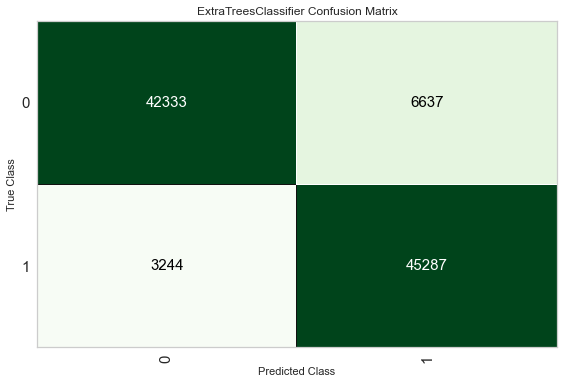

In [14]:
plot_model(catboost, plot = 'confusion_matrix')


In [20]:
catboosts = tune_model(catboost)
# predict on test set
predictions = predict_model(catboosts)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7786,0.8557,0.8702,0.7357,0.7973,0.5572,0.5668
1,0.7754,0.8544,0.8760,0.7295,0.7960,0.5507,0.5622
2,0.7690,0.8469,0.8710,0.7236,0.7905,0.5379,0.5494
3,0.7713,0.8482,0.8763,0.7245,0.7932,0.5426,0.5550
4,0.7744,0.8545,0.8674,0.7316,0.7937,0.5488,0.5585
5,0.7731,0.8484,0.8654,0.7308,0.7924,0.5462,0.5557
6,0.7709,0.8522,0.8718,0.7257,0.7921,0.5418,0.5532
7,0.7642,0.8477,0.8609,0.7216,0.7851,0.5283,0.5384
8,0.7730,0.8506,0.8707,0.7286,0.7933,0.5460,0.5567
9,0.7740,0.8521,0.8708,0.7298,0.7941,0.5480,0.5585


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7757,0.8540,0.8738,0.7293,0.7950,0.5519,0.5629


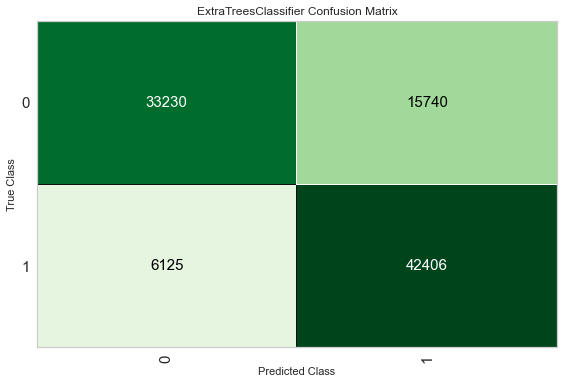

In [21]:
plot_model(catboosts, plot = 'confusion_matrix')

In [ ]:
# interpreting model
interpret_model(catboost)

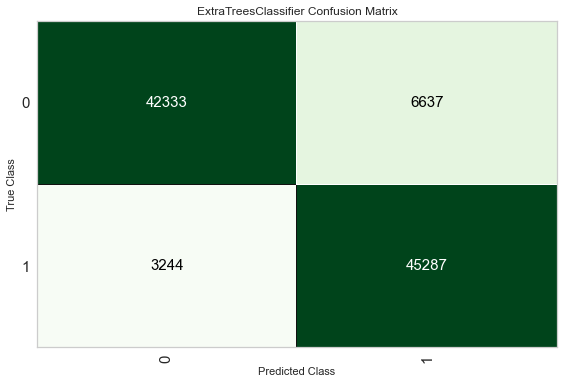

In [15]:
plot_model(catboost, plot = 'confusion_matrix')

In [16]:
final_rf = finalize_model(catboost)

In [17]:
print(final_rf)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=100, verbose=0,
                     warm_start=False)


In [18]:
unseen_predictions = predict_model(final_rf, spotify_test)


In [25]:
from pycaret.utils import check_metric

check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'], metric = "Accuracy")

0.9082

In [26]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'],metric = 'AUC')

0.908

In [27]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'], metric = "Recall")

0.9391

In [28]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'],metric = 'Precision')

0.8859

In [29]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'], metric = "F1")

0.9117

In [30]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'],metric = 'Kappa')

0.8164

In [31]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'], metric = "MCC")

0.8179

In [32]:
check_metric(unseen_predictions['billboardhit'], unseen_predictions['Label'],metric = 'MAE')

0.0918

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss



X_train, X_test, y_train, y_test = train_test_split(spotify, y, test_size=0.25, random_state=20)


pac = PassiveAggressiveClassifier(max_iter = 1000,verbose = 2)
pac_calibrated = CalibratedClassifierCV(pac) 
pac_calibrated.fit(X_train,y_train)
y_pred = pac_calibrated.predict(X_test)
#y_pred1 = pac_calibrated.predict_proba(vec_test)
score=accuracy_score(y_test,y_pred)

print(f'PAC Accuracy: {round(score*100,2)}%')
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
cm
